# Reinforcement Learning with Doom - Increasing complexity and monitoring the model

Leandro Kieliger
contact@lkieliger.ch

---
## Description

Plan:
* introduce new environment: defend the center
* solve the new environment
* relax the constraints to let the agent move in all directions
* putting in place model diagnostics
* comparing various models
* bonus: create plot that shows value function during gameplay


# Code

## Preparations

In [1]:
%load_ext autoreload
%autoreload 2

import cv2
import gym
import matplotlib.pyplot as plt
import numpy as np
import torch as th
import typing as t
import vizdoom
from stable_baselines3 import ppo
from stable_baselines3.common import callbacks
from stable_baselines3.common import evaluation
from stable_baselines3.common import policies
from torch import nn

from common import envs
from common import plotting

# Defend the center

The next scenario we are going to tackle is called "Defend the center". In this scenario, the agent is stuck in the center of a circular arena and will be attacked by monsters spawning at random intervals and locations. Here are the rewards for this scenario:

* 1 point for each ennemy killed.
* -1 point for dying.

Since there is a limit on the total ammunition of the agent, 26, the theoretical maximum for this scenario is 25. The buttons available are `ATTACK`, `TURN_LEFT` and `TURN_RIGHT`.

In [2]:
def solve_env(env_args, agent_args, n_envs, additional_callbacks, timesteps):

    # Create environments.
    env = envs.create_vec_env(n_envs, **env_args)
    eval_env = envs.create_eval_vec_env(**env_args)

    # Build the agent
    agent = ppo.PPO(policy=policies.ActorCriticCnnPolicy,
                    env=env,
                    tensorboard_log='logs/tensorboard',
                    verbose=0,
                    seed=0,
                    **agent_args)
    
    
    evaluation_callback = callbacks.EvalCallback(eval_env,
                                   n_eval_episodes=10,
                                   eval_freq=2048,
                                   best_model_save_path=f'logs/models/{env_args["scenario"]}',
                                   deterministic=True)
    
    all_callbacks = [evaluation_callback] + additional_callbacks

    # Start the training process.
    agent.learn(total_timesteps=timesteps, tb_log_name=env_args['scenario'], callback=all_callbacks)

    env.close()
    eval_env.close()

In [14]:
# Results in a 100x156 image, no pixel lost due to padding with the default CNN architecture
frame_processor = lambda frame: cv2.resize(frame[40:, 4:-4], None, fx=.5, fy=.5, interpolation=cv2.INTER_AREA)

In [ ]:
env_args = {'scenario': 'defend_the_center', 'frame_skip': 1, 'frame_processor': frame_processor}
agent_args = {'n_epochs': 3, 'n_steps': 1024, 'learning_rate': 1e-4, 'batch_size': 32}

solve_env(env_args, agent_args, 2, [], 100000)

Eval num_timesteps=4096, episode_reward=0.00 +/- 0.45
Episode length: 339.60 +/- 29.84
New best mean reward!
Eval num_timesteps=8192, episode_reward=-0.20 +/- 0.40
Episode length: 278.60 +/- 31.24
Eval num_timesteps=12288, episode_reward=1.60 +/- 0.49
Episode length: 432.40 +/- 15.41
New best mean reward!
Eval num_timesteps=16384, episode_reward=-0.50 +/- 0.67
Episode length: 282.60 +/- 67.74
Eval num_timesteps=20480, episode_reward=-0.80 +/- 0.40
Episode length: 263.80 +/- 30.11
Eval num_timesteps=24576, episode_reward=0.50 +/- 0.67
Episode length: 371.80 +/- 71.96
Eval num_timesteps=28672, episode_reward=15.50 +/- 4.22
Episode length: 1252.50 +/- 296.39
New best mean reward!


We see that we are able to solve this scenario without breaking a sweat. Let's try something more difficult.

# Defend the center (harder)


Remember that our ultimate goal is to train an agent to play Doom deathmatch against bots. We will use the scenario we just solved as a good middle to perform some experiments before jumping to the more difficult task of playing against bots. In general, it is often a good idea to start simple and progressively add complexity to the task.

The increased complexity here will arise from the fact that in a deathmatch environment, we will need to perform more actions than simply turning around and shooting. Here is the list of buttons we will be using:

```
ATTACK, TURN_LEFT, TURN_RIGHT, MOVE_FORWARD, MOVE_LEFT, MOVE_RIGHT
```

A simple solution would be to directly change the available buttons in the config file. Although this will work, you will notice that the agent will be quite slow in the sense that he can only perform one action at a time. Either shoot, turn or move. This is not a big issue in the current scenario. However, when playing later against bots running all over the place, our agent will be unfairly disadvantaged because of the limitations in its actions.

TODO: ajouter un gif d'un agent output=5 qui joue en deathmatch

Although VizDoom allows us to provide a list of button states, our model uses a discrete action space. A simple workaround is to generate all possible combination of buttons and use each combination as a single action. However, the number of such possible combination is $2^n$ where $n$ is the number of available buttons. Even is our simplecase with 6 buttons, this would mean having 64 possible outputs. If we were to add `MOVE_BACKWARD` as well, we would already be at 128 outputs. To mitigate the combinatorial explosion of our action space, we are going to forbid certain combination. Indeed, it does not make much sense to allow for example both `TURN_RIGHT` and `TURN_LEFT` to be activated at the same time. Therefore, we will remove the following combinations:

* `TURN_RIGHT` and `TURN_LEFT`
* `MOVE_RIGHT` and `MOVE_LEFT`

And we will also only allow the `ATTACK` button to be used alone. This will not hurt performance as most weapons in Doom have a cooldown period between two attacks anyway. In the end, the total number of different possible actions is given by the cartesion product of:

```

{ATTACK} + {TURN_RIGHT, TURN_LEFT, NOTHING} x {MOVE_RIGHT, MOVE_LEFT, NOTHING} x {MOVE_FORWARD, NOTHING}

or

1 + 3 x 3 x 2 = 19 possible actions

```
Since we don't want the all-zero state (no button pressed) this will give us a grand total of 18 which is much better than the 64 we could have ended up with. Here is the code to generate the action space given a list of buttons and our exclusion lists.

In [3]:
import itertools
import typing as t

from vizdoom import Button


# Buttons that cannot be used together
MUTUALLY_EXCLUSIVE_GROUPS = [
    [Button.MOVE_RIGHT, Button.MOVE_LEFT],
    [Button.TURN_RIGHT, Button.TURN_LEFT],
    [Button.MOVE_FORWARD, Button.MOVE_BACKWARD],
]

# Buttons that can only be used alone.
EXCLUSIVE_BUTTONS = [Button.ATTACK]


def has_exclusive_button(actions: np.ndarray, buttons: np.array) -> np.array:
    exclusion_mask = np.isin(buttons, EXCLUSIVE_BUTTONS)
    
    # Flag actions that have more than 1 active button among exclusive list.
    return (np.any(actions.astype(bool) & exclusion_mask, axis=-1)) & (np.sum(actions, axis=-1) > 1)


def has_excluded_pair(actions: np.ndarray, buttons: np.array) -> np.array:
    # Create mask of shape (n_mutual_exclusion_groups, n_available_buttons), marking location of excluded pairs.
    mutual_exclusion_mask = np.array([np.isin(buttons, excluded_group) for excluded_group in MUTUALLY_EXCLUSIVE_GROUPS])

    # Flag actions that have more than 1 button active in any of the mutual exclusion groups.
    return np.any(np.sum(
        # Resulting shape (n_actions, n_mutual_exclusion_groups, n_available_buttons)
        (actions[:, np.newaxis, :] * mutual_exclusion_mask.astype(int)),
        axis=-1) > 1, axis=-1)


def get_available_actions(buttons: np.array) -> t.List[t.List[float]]:
    # Create list of all possible actions of size (2^n_available_buttons x n_available_buttons)
    action_combinations = np.array([list(seq) for seq in itertools.product([0., 1.], repeat=len(buttons))])

    # Build action mask from action combinations and exclusion mask
    illegal_mask = (has_excluded_pair(action_combinations, buttons)
                    | has_exclusive_button(action_combinations, buttons))

    possible_actions = action_combinations[~illegal_mask]
    possible_actions = possible_actions[np.sum(possible_actions, axis=1) > 0]  # Remove no-op

    print('Built action space of size {} from buttons {}'.format(len(possible_actions), buttons))
    return possible_actions.tolist()

possible_actions = get_available_actions(np.array([Button.ATTACK, Button.MOVE_FORWARD, 
Button.MOVE_LEFT, Button.MOVE_RIGHT, Button.TURN_LEFT, Button.TURN_RIGHT]))
possible_actions

Built action space of size 18 from buttons [Button.ATTACK Button.MOVE_FORWARD Button.MOVE_LEFT Button.MOVE_RIGHT
 Button.TURN_LEFT Button.TURN_RIGHT]


[[0.0, 0.0, 0.0, 0.0, 0.0, 1.0],
 [0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
 [0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 1.0, 0.0, 1.0],
 [0.0, 0.0, 0.0, 1.0, 1.0, 0.0],
 [0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 1.0, 0.0, 0.0, 1.0],
 [0.0, 0.0, 1.0, 0.0, 1.0, 0.0],
 [0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0, 0.0, 1.0],
 [0.0, 1.0, 0.0, 0.0, 1.0, 0.0],
 [0.0, 1.0, 0.0, 1.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 1.0, 0.0, 1.0],
 [0.0, 1.0, 0.0, 1.0, 1.0, 0.0],
 [0.0, 1.0, 1.0, 0.0, 0.0, 0.0],
 [0.0, 1.0, 1.0, 0.0, 0.0, 1.0],
 [0.0, 1.0, 1.0, 0.0, 1.0, 0.0],
 [1.0, 0.0, 0.0, 0.0, 0.0, 0.0]]

Training the model in this more challenging environment will definitely require more training time. This is a good opportunity to log some metrics to help us monitor the training process.

# Model inspection

Stable-baselines already logs out of the box several useful metrics such as the value/policy/entropy losses, mean episode length and rewards. The next most useful quantity to log is the evolution over time of the model's weights. In particular, we'd like to make sure that our activations are well behaved. That is, they are not always zero (which would suggest we have dead neurons) and that the variance of each layer output stays away from zero as well. If this is not the case we might end up with vanishing gradient issues and ultimately poor learning performance.

I already mentioned the amazing course from FastAI's in the previous part of this series. We are going to implement several suggestions from the [10th lesson of the course](https://course19.fast.ai/videos/?lesson=10) of the course. Namely:

* Activation layer monitoring with hooks
* Kaiming initialization
* Batch/Layer normalization

## Monitoring layer activation

The first thing we need is to keep an eye on the neuron activation, especially in the first layers of our model. To do this, we will use FastAI's approach of defining hooks. A hook is a function that can be attached to a specific layer of our model and that will be called for each forward pass.

We will combine this approach with Tensorboard ability to log tensors to get the distribution over time of our layer activations. Our hooks will contain a single attribute, `activation_data`, that will store the layer's outputs.

In [4]:
from functools import partial

class Hook:
    def __init__(self, module: nn.Module, func: t.Callable):
        self.hook = None
        self.module = module
        self.func = func
        self.register()
        self.activation_data = []

    def register(self):
        # self.func will now be called on each forward pass
        self.hook = self.module.register_forward_hook(partial(self.func, self))

    def remove(self):
        self.hook.remove()

def store_activation(hook, module, inp, outp):
    """Function intented to be called by a hook on a forward pass.
    
    Args:
        hook: The hook object that generated the call.
        module: The module on which the hook is registered.
        inp: Input of the module.
        outp: Output of the module.
    """
    hook.activation_data.append(outp.data.cpu().numpy())

The second step is to define a callback that will periodically log hook data. For simplicity, we will only be logging in Tensorboard the latest activation value of each training phase. Of course, if you need more granularity, you can easily log more values. Keep in mind though that stable-baselines logger implementation aligns everything on the rollout time steps (which do not correspond to forward passes in training) when logging to Tensorboard. So you will need to do some adjustments there to either log to a file yourself or to adapt stable-baseline's implementation.

In [5]:
from stable_baselines3.common.callbacks import BaseCallback

# Logging to tensorflow
class LayerActivationMonitoring(BaseCallback):
    
    def __init__(self, verbose=0):
        super().__init__(verbose)

    def _on_rollout_start(self) -> None:
        """Called after the training phase."""
        # Remove the hooks so that they don't get called for rollout collection.
        hooks = self.model.policy.features_extractor.hooks
        for h in hooks: h.remove()

        # Log activations to tensorboard.
        for i, hook in enumerate(hooks):
            if len(hook.activation_data) > 0:
                data = hook.activation_data[-1]
                self.logger.record(f'diagnostics/activation_l{i}', data)
                self.logger.record(f'diagnostics/mean_l{i}', np.mean(data))
                self.logger.record(f'diagnostics/std_l{i}', np.std(data))
                self.logger.record(f'diagnostics/low_act_prop_l{i}', self.get_low_act(data))

    def _on_rollout_end(self) -> None:
        """Called before the training phase."""
        hooks = self.model.policy.features_extractor.hooks
        for h in hooks: h.register()

    def get_low_act(self, data, threshold=0.2):
        """Computes the proportion of activations that have value close to zero."""
        low_activation = ((-threshold <= data) & (data <= threshold))
        return np.count_nonzero(low_activation) / np.size(low_activation)

    def _on_step(self):
        pass

Finally, we attach the hooks to every activation layer and test the behaviour with a few training steps.

In [6]:
def register_hooks(model):
    model.policy.features_extractor.hooks = [
        Hook(layer, store_activation)
        for layer in model.policy.features_extractor.cnn
        if isinstance(layer, nn.ReLU) or isinstance(layer, nn.LeakyReLU)]

The following helper function will extract the list of layer outputs collected by the hook and compute some statistics on it. Namely:

* The mean of each activation layer
* The standard deviation of each activation layer
* The proportion of activations that are between -0.2 and 0.2

Finally, using the idea presented in FastAI's course, it will plot an histogram of the layer activations. The horizontal axis represents training steps (processing of one minibatch), in chronological order from left to right. The vertical axis represents the histogram bins from -7 to 7 (bottom to top). Brighter regions indicate larger histogram values.

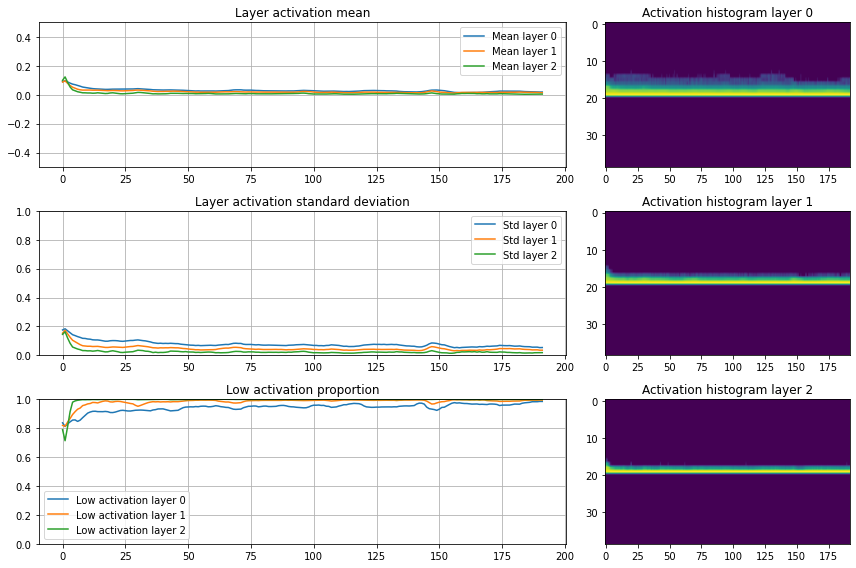

In [24]:
agent = create_and_train_one_rollout()
plotting.plot_activations(agent.policy.features_extractor.hooks)

We notice at the beginning of the training phase several potential issues. First, the variance of the output of each layer is very close to zero and there is a noticeable decrease between the first and the last layer. Also, almost all the outputs are near zero which can be seen both on the graph showing the proportion of small activations over time and the activation histogram.

Following FastAI's recommendation, we will perform two changes:

1. Use Kaiming initialization
2. Use layer normalization

In [7]:
def init_net(m: nn.Module):
    if len(m._modules) > 0:
        for subm in m._modules:
            init_net(m._modules[subm])
    elif isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, a=0.1, mode='fan_in', nonlinearity='leaky_relu')

Adding layer norm:

In [8]:
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor

class CustomCNN(BaseFeaturesExtractor):
    def __init__(self, observation_space: gym.spaces.Box, features_dim: int = 128, **kwargs):
        super().__init__(observation_space, features_dim)

        self.cnn = nn.Sequential(
            nn.LayerNorm([3, 100, 156]),
            
            nn.Conv2d(3, 32, kernel_size=8, stride=4, padding=0, bias=False),
            nn.LayerNorm([32, 24, 38]),
            nn.LeakyReLU(**kwargs),
            
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=0, bias=False),
            nn.LayerNorm([64, 11, 18]),
            nn.LeakyReLU(**kwargs),
            
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=0, bias=False),
            nn.LayerNorm([64, 9, 16]),
            nn.LeakyReLU(**kwargs),
            
            nn.Flatten(),
        )

        self.linear = nn.Sequential(
            nn.Linear(9216, features_dim, bias=False),
            nn.LayerNorm(features_dim),
            nn.LeakyReLU(**kwargs),
        )

    def forward(self, observations: th.Tensor) -> th.Tensor:
        return self.linear(self.cnn(observations))

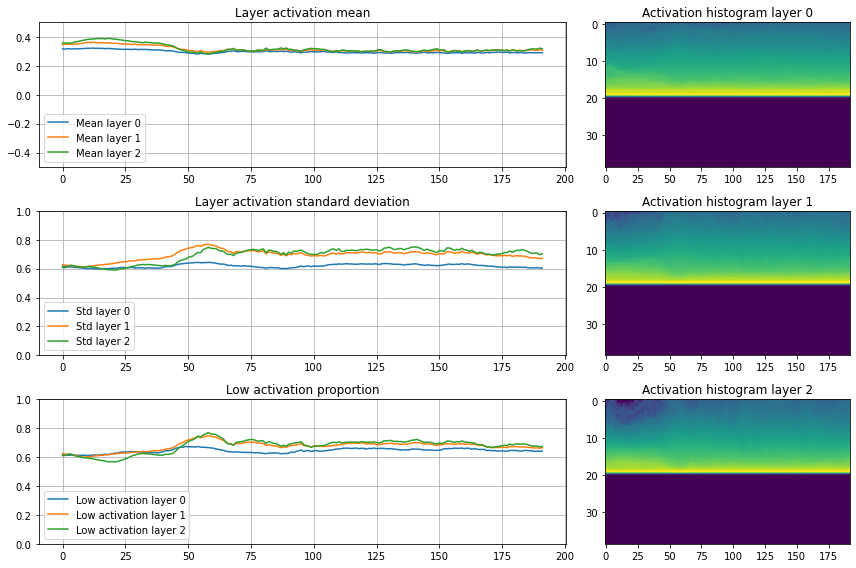

In [27]:
agent = create_and_train_one_rollout(policy_kwargs={'features_extractor_class': CustomCNN}, init_func=init_net)
plotting.plot_activations(agent.policy.features_extractor.hooks)

We notice now that the variance is better behaved, starting around 0.6. In particular, the full range of the ReLU activation function is now used by our layers.

# Comparing the models

Solving the new scenario with different norms gives the following results. Averaging 6 consecutive runs per method. The coloured region denotes the error mean: $ \frac{\sigma}{\sqrt{n}}$.

Unfortunately, although adding normalization improved the telemetry of our model, it seems to have very little impact on the training performance. 

![Comparison normalization](figures/comparison_norm.png)

In [9]:
env_args = {
    'scenario': 'defend_the_center_relaxed', 
    'frame_skip': 4, 
    'frame_processor': frame_processor
}

agent_args = {
    'n_epochs': 3,
    'n_steps': 4096,
    'learning_rate': 1e-4,
    'batch_size': 32,
    'policy_kwargs': {'features_extractor_class': CustomCNN}
}

# Create environments.
env = envs.create_vec_env(2, **env_args)
eval_env = envs.create_eval_vec_env(**env_args)

# Build the agent
agent = ppo.PPO(policy=policies.ActorCriticCnnPolicy,
                env=env,
                tensorboard_log='logs/tensorboard',
                verbose=0,
                seed=0,
                **agent_args)

register_hooks(agent)
init_net(agent.policy)
layer_callback = LayerActivationMonitoring()
agent.learn(total_timesteps=1024, callback=layer_callback)

evaluation_callback = callbacks.EvalCallback(eval_env,
                               n_eval_episodes=10,
                               eval_freq=2048,
                               best_model_save_path=f'logs/models/{env_args["scenario"]}',
                               deterministic=True)

all_callbacks = [evaluation_callback, layer_callback] 

# Start the training process.
agent.learn(500000, tb_log_name=env_args['scenario'], callback=all_callbacks)

env.close()
eval_env.close()

ViZDoomUnexpectedExitException: Controlled ViZDoom instance exited unexpectedly.

# Playing against bots 

We are now almost ready to tackle the task of playing Doom deathmatch against programmed bots. Setting up a deathmatch game requires a slightly different config for VizDoom that is show here below.

First, we need to adapt the environment wrapper to handle bots and the deathmatch mechanics. In particular, we need to keep track of the "frags" obtained by our agent as this will constitute our reward basis. A "frag" correspond to an ennemy killed. We will reward the agent with one point per kill. Note that in the case of a suicide (which can happen when using rocket launchers for example), the frag count will decrease by one. Conveniently, this will work as a penalty to discourage such outcomes.

The snippet below has all the comments required to understand to adaptations made to the environment.

![Map presentation](figures/flatmap.png)

In [9]:
from gym import spaces
from vizdoom.vizdoom import GameVariable

class DoomWithBots(envs.DoomEnv):

    def __init__(self, 
                 name: str,
                 game: vizdoom.DoomGame,
                 frame_processor: t.Callable,
                 frame_skip: int = 4,
                 n_bots: int = 8):
        super().__init__(game, frame_processor, frame_skip)

        self.name = f'Agent {name}'
        self.n_bots = n_bots
        self.last_frags = 0       
        self.tic_rate = frame_skip
        
        self.possible_actions = get_available_actions(np.array(game.get_available_buttons()))
        self.action_space = spaces.Discrete(len(possible_actions))
                
        self._reset_bots()

    def step(self, action):
        # Apply action
        _ = self.game.make_action(self.possible_actions[action], self.frame_skip)
       
        frags = self.game.get_game_variable(GameVariable.FRAGCOUNT)
        reward = frags - self.last_frags
        self.last_frags = frags
    
        self._respawn_if_dead()

        # Episode end needs to be checked last because respawning takes 
        # a few ticks and might send us beyond the time limit.
        done = self.game.is_episode_finished()

        self.state = self._get_frame(done)

        return self.state, reward, done, {}

    def reset(self):
        self._print_state()
        state = super().reset()

        self.last_frags = 0
        self._reset_bots()

        return state

    def _respawn_if_dead(self):
        if not self.game.is_episode_finished():
            # Check if player is dead
            if self.game.is_player_dead():
                self.game.respawn_player()
                
    def _reset_bots(self):
        self.game.send_game_command('removebots')
        for i in range(self.n_bots):
            self.game.send_game_command('addbot')

    def _print_state(self):
        server_state = self.game.get_server_state()
        player_scores = list(zip(server_state.players_names, server_state.players_frags, server_state.players_in_game))
        player_scores = sorted(player_scores, key=lambda tup: tup[1])

        print('Results:')
        for player_name, player_score, player_ingame in player_scores:
            if player_ingame:
                print(f'{player_name}: {player_score}')
        print()

The other adaptation required is to pass several game arguments via the `add_game_args` function.

In [10]:
from stable_baselines3.common import vec_env

def create_env_with_bots(name, scenario, **kwargs) -> envs.DoomEnv:
    # Create a VizDoom instance.
    game = vizdoom.DoomGame()
    game.load_config(f'scenarios/{scenario}.cfg')
    game.add_game_args('-host 1 -deathmatch +cl_run 1 +name AGENT +colorset 0' +
                       '+sv_forcerespawn 1 +sv_respawnprotect 1 +sv_nocrouch 1')
    game.init()

    return DoomWithBots(name, game, **kwargs)

def create_vec_env_with_bots(n_envs=1, **kwargs) -> vec_env.VecTransposeImage:
    return vec_env.VecTransposeImage(
        vec_env.DummyVecEnv(
            [lambda: create_env_with_bots(i, **kwargs) for i in range(n_envs)]
        )
    )

And that's it, we're ready to go. 



In [16]:
# Create environments.
env_args = {
    'scenario': 'deathmatch_simple',
    'frame_skip': 4,
    'frame_processor': frame_processor,
}

agent_args = {
    'n_epochs': 3,
    'n_steps': 4096,
    'learning_rate': 1e-4,
    'batch_size': 32,
    'policy_kwargs': {'features_extractor_class': CustomCNN}
}

env = create_vec_env_with_bots(n_envs=4, **env_args)
eval_env = create_vec_env_with_bots(n_envs=1, **env_args)

Built action space of size 18 from buttons [Button.ATTACK Button.MOVE_FORWARD Button.MOVE_LEFT Button.MOVE_RIGHT
 Button.TURN_RIGHT Button.TURN_LEFT]
Built action space of size 18 from buttons [Button.ATTACK Button.MOVE_FORWARD Button.MOVE_LEFT Button.MOVE_RIGHT
 Button.TURN_RIGHT Button.TURN_LEFT]
Built action space of size 18 from buttons [Button.ATTACK Button.MOVE_FORWARD Button.MOVE_LEFT Button.MOVE_RIGHT
 Button.TURN_RIGHT Button.TURN_LEFT]
Built action space of size 18 from buttons [Button.ATTACK Button.MOVE_FORWARD Button.MOVE_LEFT Button.MOVE_RIGHT
 Button.TURN_RIGHT Button.TURN_LEFT]
Built action space of size 18 from buttons [Button.ATTACK Button.MOVE_FORWARD Button.MOVE_LEFT Button.MOVE_RIGHT
 Button.TURN_RIGHT Button.TURN_LEFT]


In [17]:
# Build the agent
agent = ppo.PPO(policy=policies.ActorCriticCnnPolicy,
                env=env,
                **agent_args,
                tensorboard_log='logs/tensorboard',
                verbose=0,
                seed=0)

register_hooks(agent)
init_net(agent.policy)
    
# Callbacks
layer_callback = LayerActivationMonitoring()
eval_callback = callbacks.EvalCallback(eval_env,
                    n_eval_episodes=10,
                    eval_freq=8192,
                    log_path='logs/evaluations/deathmatch_simple',
                    best_model_save_path='logs/models/deathmatch_simple')    


agent.learn(total_timesteps=2000000, tb_log_name='deathmatch_simple', callback=[eval_callback, layer_callback])

Results:
AGENT: 0

Results:
AGENT: 0

Results:
AGENT: 0

Results:
AGENT: 0



KeyboardInterrupt: 

In [ ]:
env.close()
eval_env.close()

TODO: add mean over six runs for deathmatch setup

# Discussion

* We see that the performance is really bad
* Why is that?
* Missing piece: reward shaping + curriculum learning
* Conclusion with teaser for next part


# Conclusion